##Diseño Evolutivo de Redes Neuronales Artificiales
##Baseline
Basado en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Se desea reproducir los resultados del paper en ANN para el S&P 500.
Se usan datos diarios de cierre del S&P 500 (GSPC) obtenidos de Yahoo Finance.
Se calcularon los indicadores técnicos según las fórmulas del paper.

###Importar paquetes

In [0]:
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
from matplotlib import pyplot as plt

###Parámetros de configuración
La idea es agrupar aquí los parámetros configurables.


In [0]:
p = {"local_file" : "baseline.csv",
     "url" : "https://raw.githubusercontent.com/"+
             "jmacostap/webstore/master/baseline.csv",
     "cache_dir" : "/content",
     "scaler" : skp.MinMaxScaler(),
     "test_fraction" : 0.20,  # 20% of samples for test data
     "neurons" : 9,
     "activation" : "sigmoid",  # for the hidden layer
     "output_activation" : "linear",  # for the output layer
     "optimizer" : tf.keras.optimizers.SGD(
         learning_rate=0.3,
         momentum=0.2,
         nesterov=False),
     "metrics" : ["mae","mape"],
     "loss" : "mse",  # could be mae or mse
     "epochs" : 500,  # training epochs
     "batch_size" : 100,
     "shuffle" : True,  # the training data
     "verbose" : 0,  # verbose training
}


###Leer los datos de entrada directamente del repositorio de GitHub

In [3]:
path_to_downloaded_file = tf.keras.utils.get_file(
    p["local_file"],
    p["url"],
    cache_dir=p["cache_dir"],
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")
print(f"{data.shape} samples read")
# Extract targets
targets = np.reshape(data[:, -1], (-1,1))
print(f"Targets to be used: {targets.shape}")
# Extraer los features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")
# Normalizar los datos a [0,1]
data_scaler = p["scaler"]
data = data_scaler.fit_transform(data)
targets_scaler = p["scaler"]
targets = targets_scaler.fit_transform(targets)
# Separar datos de prueba
test_fraction = np.int(len(data)*p["test_fraction"])
print(f"Test fraction: {test_fraction}")
train_targets = targets[:-test_fraction]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_fraction]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_fraction:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_fraction:]
print(f"Test samples: {test_data.shape}")

(3022, 20) samples read
Targets to be used: (3022, 1)
Samples to be used: (3022, 19)
Test fraction: 604
Train targets: (2418, 1)
Train samples: (2418, 19)
Test targets: (604, 1)
Test samples: (604, 19)


###Crear el modelo

In [4]:
# Ensure reproducibility
np.random.seed(31416)  # numpy
tf.random.set_seed(31416)  # keras

# Define the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            p["neurons"],
            activation=p["activation"],
            input_shape=(data.shape[1],),
        ),
        tf.keras.layers.Dense(
            1,
            activation=p["output_activation"],
        ),
    ]
)

# Create the model
model.compile(
    optimizer=p["optimizer"],
    metrics=p["metrics"],
    loss=p["loss"],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 180       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________
None


###Entrenar el modelo

In [5]:
# Train the model
history = model.fit(
    train_data,
    train_targets,
    epochs=p["epochs"],
    batch_size=p["batch_size"],
    shuffle=p["shuffle"],
    verbose=p["verbose"],
    validation_split=p["test_fraction"],
    )
loss_error, mae_error, mape_error = model.evaluate(train_data, train_targets)
print(f"Test error: {loss_error}, MAE: {mae_error}, MAPE: {mape_error}")

76/76 [==============================] - 0s 1ms/step - loss: 9.5185e-04 - mae: 0.0212 - mape: 107050.3906
Test error: 0.0009518456645309925, MAE: 0.02117173746228218, MAPE: 107050.390625


###Visualizar el entrenamiento

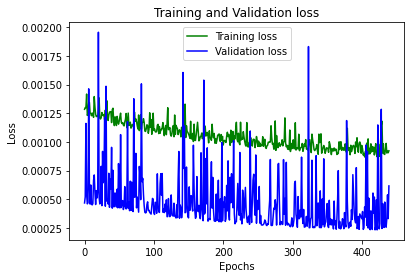

In [6]:
fro=60  # Avoid autoscale issues
plt.plot(history.history['loss'][fro:], 'g', label='Training loss')
plt.plot(history.history['val_loss'][fro:], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###Probar el modelo con los datos de prueba

In [7]:
loss_error, mae_error, mape_error = model.evaluate(test_data, test_targets)
print(f"Test error: {loss_error}, MAE: {mae_error}, MAPE: {mape_error}")

19/19 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0321 - mape: 7.3333
Test error: 0.0012753783958032727, MAE: 0.0320524126291275, MAPE: 7.333268165588379
